# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.376038
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$

因为Li = -log(softmax(fyi))，这里的fyi是正确分类的打分结果（为什么是正确分类的？），而一开始由于W被随机赋值，且num_classes=10即十个分类，所以softmax计算后每一个类别的值或者说概率都应该是1/10，即-log(0.1)。



In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
# 梯度检查，这个真的非常重要，因为我第一次求softmax梯度公式就算错了
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
# 有正则项的梯度检查
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.970109 analytic: 1.970109, relative error: 1.029302e-08
numerical: -2.026800 analytic: -2.026800, relative error: 3.590826e-09
numerical: -2.311185 analytic: -2.311185, relative error: 1.220102e-08
numerical: -0.287792 analytic: -0.287793, relative error: 1.381306e-07
numerical: -1.344683 analytic: -1.344683, relative error: 6.442016e-09
numerical: 0.711456 analytic: 0.711456, relative error: 9.476566e-09
numerical: 0.440809 analytic: 0.440809, relative error: 5.653874e-08
numerical: -2.117513 analytic: -2.117513, relative error: 2.267218e-09
numerical: 6.108612 analytic: 6.108611, relative error: 7.625906e-09
numerical: 0.471742 analytic: 0.471742, relative error: 2.519204e-08
numerical: 0.007498 analytic: 0.007498, relative error: 1.108322e-06
numerical: -0.104980 analytic: -0.104980, relative error: 4.320554e-07
numerical: -1.713498 analytic: -1.713498, relative error: 1.534149e-09
numerical: 0.180271 analytic: 0.180271, relative error: 7.157042e-08
numerical: -0.403311

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
# 实现向量化的损失和梯度计算
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
# 这里是求了两个梯度矩阵的F范数，衡量之间的差异
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.376038e+00 computed in 0.085783s
vectorized loss: 2.376039e+00 computed in 0.175550s
Loss difference: 0.000001
Gradient difference: 0.000000


In [11]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
# 熟悉的调超参，写过一次就比较好写了

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 2e-7, 3e-7, 4e-7, 5e-7]
regularization_strengths = [1e3, 5e3, 1e4, 2e4, 3e4, 4e4, 5e4, 1e5, 5e5]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        loss_history = softmax.train(X_train, y_train, lr, rs, num_iters=3000, batch_size=200, verbose=False)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.sum(y_train_pred == y_train) / X_train.shape[0]
        y_validation_pred = softmax.predict(X_val)
        val_accuracy = np.sum(y_validation_pred == y_val) / X_val.shape[0]
        results[(rs, lr)] = (train_accuracy, val_accuracy)
        if (val_accuracy > best_val):
            best_val = val_accuracy
            best_softmax = softmax

# pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e+03 reg 1.000000e-07 train accuracy: 0.315429 val accuracy: 0.341000
lr 1.000000e+03 reg 2.000000e-07 train accuracy: 0.376306 val accuracy: 0.384000
lr 1.000000e+03 reg 3.000000e-07 train accuracy: 0.395592 val accuracy: 0.395000
lr 1.000000e+03 reg 4.000000e-07 train accuracy: 0.399265 val accuracy: 0.411000
lr 1.000000e+03 reg 5.000000e-07 train accuracy: 0.401102 val accuracy: 0.401000
lr 5.000000e+03 reg 1.000000e-07 train accuracy: 0.370694 val accuracy: 0.376000
lr 5.000000e+03 reg 2.000000e-07 train accuracy: 0.371408 val accuracy: 0.372000
lr 5.000000e+03 reg 3.000000e-07 train accuracy: 0.369980 val accuracy: 0.381000
lr 5.000000e+03 reg 4.000000e-07 train accuracy: 0.373265 val accuracy: 0.386000
lr 5.000000e+03 reg 5.000000e-07 train accuracy: 0.368429 val accuracy: 0.392000
lr 1.000000e+04 reg 1.000000e-07 train accuracy: 0.356041 val accuracy: 0.369000
lr 1.000000e+04 reg 2.000000e-07 train accuracy: 0.356633 val accuracy: 0.363000
lr 1.000000e+04 reg 3.000000

In [12]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.384000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$

问题是，把一个新的数据点加进训练集，SVM的loss可能不会改变，是不是一定会改变Softmax的loss？我认为题目描述是正确的，一定会变。

$\color{blue}{\textit Your Explanation:}$

对SVM来说，用的是合页损失函数，加一个数据点进来如果分类正确，syi > sj + Δ，那么Loss_i = 0；

对Softmax来说，用的是交叉熵损失函数，加一个数据点进来一定会增加大小约为（仅算data loss项）-log(P_newpoint)的损失，P_newpoint指的是Softmax(score(X))。

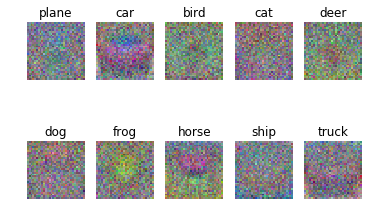

In [13]:
# Visualize the learned weights for each class
# 学习一下这一段的写法
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

所谓softmax其实就是归一化指数函数，有很多地方可以用到（具体呢？？？
激活函数？softmax和svm是不是也可以表示成NN的那种网络图形式？这段待会删掉，自己解答。https://zhuanlan.zhihu.com/p/25723112

指的是，只有前两层是线性分类器本身，不包括最后一层的激活函数是吗？softmax函数不能归到交叉熵损失函数里面，它也不是打分函数，是个独立于二者之外的激活函数，是这个意思吧？

svm用合页是为了让margin足够大(Δ)，话说按照上面那句话的思路，svm的激活函数是什么？softmax为什么用交叉熵作为损失函数？

其他的总结跟svm想说的差不多，区别是softmax完全是我独立实现的，加深了对这部分知识的认识。

还有很多问题，基本都是理论上的，还没有解决，下午去蹭机器学习问一下老师。算了，好像问题都被我自己解决了，再想想问题，另外这部分的代码还没有对照完。